In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
import copy
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from sklearn.linear_model import LinearRegression
import sys
sys.setrecursionlimit(10000)

# Clustering

In [2]:
df = pd.read_csv('all_annotated.csv')
df

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
0,FBtr0114258,CR41571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,FBtr0346770,CG45784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,FBtr0302440,CR12798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,FBtr0302347,CR40182,23.712564,11.967821,20.767498,13.566818,18.802116,26.802691,22.819895,11.682728,21.894249,13.922059,16.482141,12.622680,31.800016,22.883186,14.330216,17.20257
4,FBtr0346769,CG45783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34713,FBtr0114187,CR40502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
34714,FBtr0304147,CR40719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
34715,FBtr0114216,CR40679,2.011199,0.000000,7.994137,2.064200,3.141665,0.000000,1.519102,9.190801,13.475658,1.771435,4.649351,7.004174,6.904506,0.835856,1.151747,1.98591
34716,FBtr0114222,CR40743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [3]:
df['Keep']=np.where(df.median(axis=1,numeric_only=True)>0,True,False)
df = df.loc[df['Keep'] == True]
# apply log2(FPKM+0.1) transformation to data
log_fpkm=df.apply(lambda x:np.log2(x+0.1) if np.issubdtype(x.dtype, np.number) else x)
log_fpkm=log_fpkm.drop(['Keep'], axis = 1)
log_fpkm

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,FBtr0302347,CR40182,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
8,FBtr0113885,Parp,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
9,FBtr0301810,Alg-2,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
10,FBtr0113895,Tim17b,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
11,FBtr0345179,Tim17b,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,FBtr0100884,mt:Cyt-b,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
34665,FBtr0100886,mt:ND1,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
34667,FBtr0100888,mt:lrRNA,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
34684,FBtr0114261,CR41590,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


In [63]:
# prepare data for clustering by turning into np array
clust=log_fpkm.to_numpy()
clust_val = clust[:,2:]
clust_trans=np.transpose(clust_val)

# cluster the data
z=linkage(clust_val)
z_trans=linkage(clust_trans)

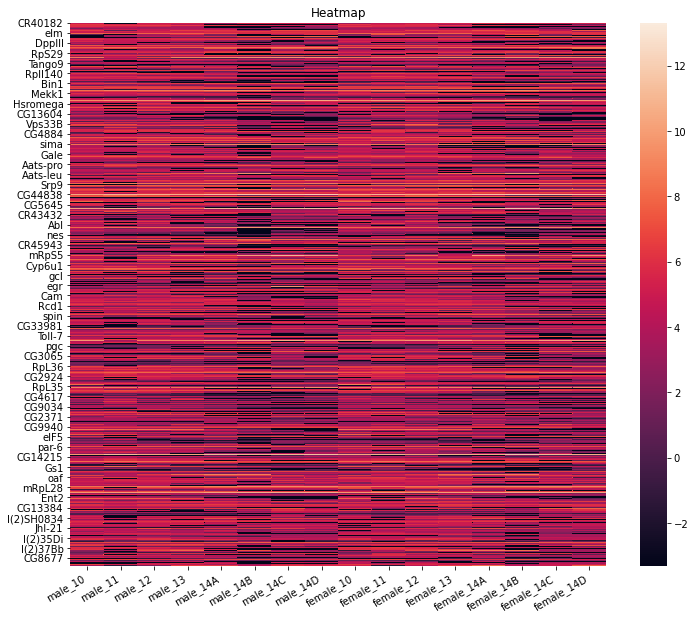

In [74]:
# Plot heatmap
fig, ax = plt.subplots(figsize = (12,10))
# rename log_fpkm indices
log_fpkm.index = log_fpkm.to_numpy()[:,1]
ax = sns.heatmap(log_fpkm.iloc[:,2:])
ax.set_title('Heatmap')
plt.xticks(rotation=30, ha='right')
plt.show()

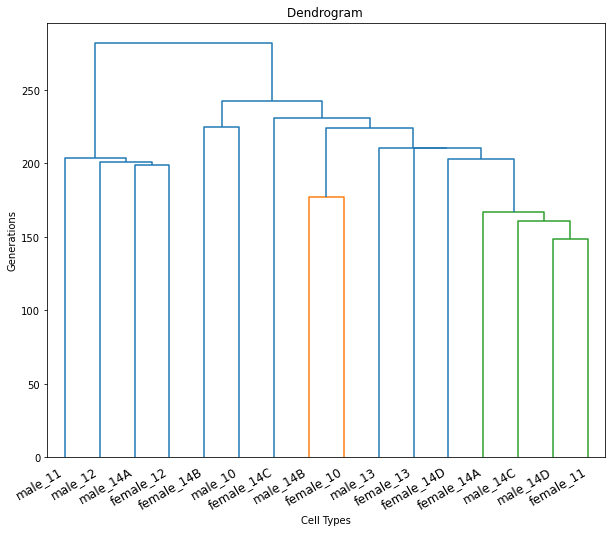

In [87]:
# get labels
col_names=[]
cols=log_fpkm.iloc[:,2:].columns.tolist()
for j in leaves_list(z_trans):
    col_names.append(cols[j])
    
# Plot dendrogram
fig,ax=plt.subplots(figsize=(10,8))
dendrogram(z_trans,labels=col_names)
plt.xticks(rotation=30, ha='right')
ax.set_title("Dendrogram ")
ax.set_xlabel("Cell Types")
ax.set_ylabel("Generations")
plt.show()

# Differential expression

In [92]:
# mark stages
gene_names=[]
p =[]
for index,row in log_fpkm.iterrows():
    x=[10,10,11,11,12,12,13,13,14,14,14,14,14,14,14,14]
    y=[row['male_10'],row['female_10'],row['male_11'],row['female_11'],row['male_12'],
       row['female_12'],row['male_13'],row['female_13'],row['male_14A'],row['male_14B'],row['male_14C'],
       row['male_14D'],row['female_14A'],row['female_14B'],row['female_14C'],row['male_14D']]
    #linear model, adding a constant to independent variable 
    y2=sm.add_constant(y)
    model=sm.OLS(x,y2)
    model_test=model.fit()
    gene_names.append(index)
    p.append(model_test.pvalues[1])

In [93]:
#sets up arrays for QQ plot 
p2=p.copy()
p2.sort(reverse=False)
uniform = []
for x in range(len(p2)):
    uniform.append((x+1)/len(p2))

log_uniform = []
for x in uniform:
    log_uniform.append(-1*np.log10(x))

log_p = []
for x in p2:
    log_p.append(-1*np.log10(x))

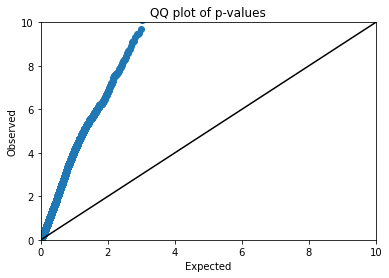

In [94]:
##QQ plot
fig, ax = plt.subplots()

ax.scatter(log_uniform, log_p)
ax.plot([10,0], [10, 0], color = "black")

plt.xlim([0, 10])
plt.ylim([0, 10])
plt.xlabel("Expected")
plt.ylabel("Observed")
ax.set_title("QQ plot of p-values")
plt.show()

In [96]:
# Report list of genes with false discovery rate 
corrected = fdrcorrection(p,alpha=0.1)
relevant_genes=[]
for i in range(len(corrected[0])): 
    #Only choose values less than .1
    if corrected[1][i]<0.1:
        relevant_genes.append(gene_names[i])

print("List of genes that are significant:")
print(relevant_genes)

List of genes that are significant:
['Tim17b', 'CG41128', 'CG12581', 'CG12582', 'CG12582', 'CG14641', 'abs', 'Vps24', 'CG9776', 'hkb', 'CG11739', 'CG11739', 'CG9855', 'CG9855', 'CG14647', 'lost', 'srl', 'eIF3-S10', 'CG31523', 'CG31523', 'CG14651', 'Fip1', 'CG9775', 'CG9775', 'rpk', 'CG9769', 'tacc', 'atms', 'Hus1-like', 'Gnf1', 'corto', 'CG12163', 'CG12173', 'Hph', 'Hph', 'Hph', 'CR45033', 'Prosbeta7', 'Prosbeta7', 'RpII18', 'CG14667', 'PEK', 'Snr1', 'Hdac3', 'CG45100', 'ksr', 'ksr', 'ksr', 'CG31550', 'CG2519', 'Pcmt', 'Snm1', 'rev7', 'noi', 'Vha26', 'Vha26', 'kra', 'Atu', 'CG2911', 'RpL13A', 'snoRNA:Me28S-U2134a', 'CG31551', 'CG31549', 'CG31549', 'CG31546', 'CG31548', 'MED27', 'Xe7', 'Rab23', 'CG2100', 'CG2100', 'Sym', 'CG2091', 'CG2051', 'Rpn5', 'CG1218', 'CG10979', 'CG10979', 'Hpr1', 'CG2023', 'CG2023', 'Rm62', 'SmD2', 'CG18048', 'CG42724', 'CG42724', 'TfIIFalpha', 'Dmtn', 'CG1307', 'CG1307', 'zen2', 'zen2', 'zen', 'bcd', 'bcd', 'CR45593', 'CR44930', 'ftz', 'CR44931', 'CR45559', 'CG

In [49]:
# Control for sex
sex_genes=[]
sex_p =[]
beta=[]
for index,row in log_fpkm.iterrows():
    x=[10,10,11,11,12,12,13,13,14,14,14,14,14,14,14,14]
    y=[[row['male_10'],0],[row['female_10'],1],
      [row['male_11'],0],[row['female_11'],1],
      [row['male_12'],0],[row['female_10'],1],
      [row['male_13'],0],[row['female_13'],1],
      [row['male_14A'],0],[row['female_14A'],1],
      [row['male_14B'],0],[row['female_14B'],1],
      [row['male_14C'],0],[row['female_14A'],1],
      [row['male_14D'],0],[row['female_14D'],1]]
    y2=sm.add_constant(y)
    model=sm.OLS(x,y2)
    model_test=model.fit()
    sex_genes.append(index)
    sex_p.append(model_test.pvalues[1])
    beta.append(model_test.params[1])


In [50]:
# Report list of genes with false discovery rate while controlling for sex
sex_corrected=fdrcorrection(sex_p,alpha=0.1)
significant=[]
i=0
sex_relevant =[]
#goes through list of genes and adds them to a list if they are 
while i<len(sex_corrected[0]): 
    if sex_corrected[1][i]<0.1:
        sex_relevant.append(sex_genes[i])
        significant.append("Yes")
    else:
        significant.append("No")
    i+=1
    
print("List of genes that are significant:")
print(sex_relevant)

List of genes that are significant:
['Parp', 'Tim17b', 'CG41128', 'CG12581', 'CG14641', 'abs', 'Vps24', 'CG9776', 'hkb', 'CG11739', 'CG11739', 'CG9855', 'CG9855', 'CG14647', 'lost', 'srl', 'eIF3-S10', 'CG31523', 'Fip1', 'CG9775', 'CG9775', 'rpk', 'CG9769', 'tacc', 'atms', 'Hus1-like', 'Gnf1', 'corto', 'corto', 'corto', 'corto', 'CG2604', 'CG12163', 'CG12173', 'Hph', 'Hph', 'Hph', 'CR45033', 'Prosbeta7', 'Prosbeta7', 'RpII18', 'CG14667', 'PEK', 'Snr1', 'Hdac3', 'CG45100', 'ksr', 'ksr', 'ksr', 'CG31550', 'Pcmt', 'Snm1', 'rev7', 'noi', 'kra', 'Atu', 'CG2911', 'RpL13A', 'snoRNA:Me28S-U2134a', 'CG31551', 'CG31549', 'CG31548', 'Sec23', 'MED27', 'Rab23', 'CG2100', 'CG2100', 'Sym', 'Madm', 'CG2091', 'CG2051', 'Rpn5', 'CG1218', 'CG10979', 'CG10979', 'Hpr1', 'CG2023', 'CG2023', 'Rm62', 'SmD2', 'CG18048', 'CG42724', 'CG42724', 'TfIIFalpha', 'CG9727', 'CG1307', 'CG1307', 'agt', 'zen2', 'zen2', 'zen', 'bcd', 'bcd', 'CR45593', 'CR44930', 'ftz', 'CR44931', 'CR45559', 'CG1943', 'Ref1', 'Dpck', 'CR4590

In [102]:
# list of genes that are relevant
i=0
for gene in sex_relevant:
    if gene in relevant_genes:
        i+=1

print("Percentage overlap: "+str(i/len(relevant_genes)*100)+"%")

Percentage overlap: 90.64565327910523%


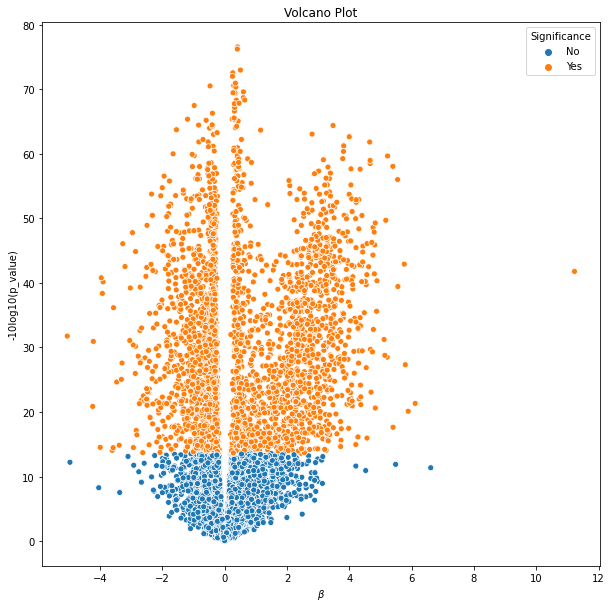

In [99]:
#volcano plot
volcano_plot={'-10log10(p_value)':-10*np.log10(sex_p),r'$\beta$': beta,'significant':significant}
volcano_data=pd.DataFrame(volcano_plot)
fig,ax=plt.subplots(figsize=(10,10))
ax.set_title("Volcano Plot")

#hue has a bug, so couldn't just get it from the Data frame 
sns.scatterplot(data=volcano_data, x=r"$\beta$",y="-10log10(p_value)",hue=volcano_data.significant.to_list())
plt.legend(title="Significance")
plt.show()